### Variable Aggregation and Feature Engineering 

In [12]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from constants import DATA_DIR, DF_FEATURES

In [13]:
pd.set_option("display.max_columns",30)
pd.set_option("display.max_rows",100)

In [14]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Dataframe for the Baseline Model
Mean of past N-1 games for each statistic when predicting N-th game performance

In [27]:
def generate_baseline(df):    
    baseline = {'Date':[], 'Name':[], 'FPTS':[], 'PTS':[], '3P':[], 'AST':[],
                'TRB':[], 'STL':[], 'BLK':[], 'TOV':[], 'DD':[], 'TD':[]}

    for i in tqdm(range(df.shape[0])):
        date = df.loc[i,'Date']
        name = df.loc[i,'Name']    

        df_name = df.loc[df['Name']==name].reset_index(drop=True)
        index = df_name.loc[df_name['Date']==date].index[0]
 
        # Check if there is past statistics available
        # Same baseline as DraftKings official data where season average is taken
        if index >= 1:
            df_past = df_name[0:index].reset_index(drop=True)

            for key in baseline.keys():
                if key in ['Date', 'Name', 'FPTS']:
                    baseline[key].append(df_name.loc[index, key])

                else:
                    baseline[key].append(df_past[key].mean())
                    
    return pd.DataFrame(baseline)

### Additional Statistics and Recency Effect

In [16]:
def draw_weights():
    weights_dic = {}
    weighting = ['sqrt_0.5','linear_1.0', 'quad_2.0']

    for key in weighting:
        weights = np.array([np.power(i, float(key[-3:])) for i in range(1,11)])
        weights = weights/weights.sum()
        weights_dic[key[:-4]] = weights

    sns.set_style("darkgrid")

    for key in weights_dic.keys():
        plt.plot(weights_dic[key])

    plt.xlabel('n-th game', fontsize=12)
    plt.ylabel('Weight', fontsize=12)
    plt.xticks([i for i in range(0,10)], [i for i in range(1,11)])
    plt.show()

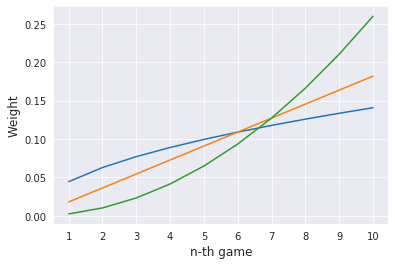

In [17]:
draw_weights()

In [31]:
%%cython
def calculate_weighted_mean(list weights, values):
    n = len(weights)
    weighted_sum = [weights[i] * values[i] for i in range(n)]
    weighted_mean = sum(weighted_sum) / sum(weights)
    
    return weighted_mean

In [30]:
def generate_features(df, weighting):
    data = {'Date':[], 'Name':[], 'FPTS':[], 
            # New feature
            'Rest':[], 'Value':[], 'FPTS_std':[],
            # Basic 9 Variables
            'PTS':[], '3P':[], 'AST':[], 'TRB':[], 'STL':[], 'BLK':[], 'TOV':[], 'DD':[], 'TD':[],
            # Additional Variables from Basketball-Reference.com
            'MP':[], 'FT':[], 'FTA':[], 'FGA':[], '3PA':[], 'DRB':[], 'ORB':[],
            # Advanced Statistics from Basketball-Reference.com
            'USG_perc':[], 'DRtg':[], 'ORtg':[], 'AST_perc':[], 'DRB_perc':[], 'ORB_perc':[],
            'BLK_perc':[], 'TOV_perc':[], 'STL_perc':[], 'eFG_perc':[], 'FG_perc':[], '3P_perc':[], 'FT_perc':[]
           }

    for i in tqdm(range(df.shape[0])):
        date = df.loc[i,'Date']
        name = df.loc[i,'Name']    

        df_name = df.loc[df['Name']==name].reset_index(drop=True)
        index = df_name.loc[df_name['Date']==date].index[0]
        
        # Generate features from the past 10 games
        if index >= 10:
            df_past = df_name[index-10:index].reset_index(drop=True)

            # Consider the number of days between the current game and the previous game
            current = datetime.strptime(str(df_name.loc[index, 'Date']), '%Y%m%d')
            previous = datetime.strptime(str(df_past.loc[df_past.shape[0]-1, 'Date']), '%Y%m%d')
            rest = current - previous

            data['Rest'].append(rest.days)

            # Weights higehr towards the most recent game
            if weighting == 'linear':
                weights = [i for i in range(1,11)]

            elif weighting == 'quad':
                weights = [i**2 for i in range(1,11)]

            elif weighting == 'sqrt':
                weights = [i**(1/2) for i in range(1,11)]

            for key in data.keys():
                if key in ['Date', 'Name', 'FPTS']:
                    data[key].append(df_name.loc[index, key])
                elif key == 'FPTS_std':
                    data[key].append(df_past['FPTS'].std())
                elif key != 'Rest':
                    weighted_mean = calculate_weighted_mean(weights, df_past[key])
                    data[key].append(weighted_mean)
        
    return pd.DataFrame(data)

### Add Roster Availability 

In [29]:
def add_roster_info(df):
    df['Rota_All'] = [0 for i in range(df.shape[0])]
    df['Rota_Pos'] = [0 for i in range(df.shape[0])]

    for date in tqdm(list(set(df['Date']))):
        for team in list(set(df['Team'])):
            df_rota = df.loc[(df['Date']==date) & (df['Team']==team)]

            if df_rota.shape[0] != 0:
                rota_all = df_rota.shape[0]

                for pos in ['PG','SG', 'F', 'C']:
                    df_pos = df_rota.loc[df_rota[pos]==1]
                    rota_pos = df_pos.shape[0]

                    df.loc[(df['Date']==date) & (df['Team']==team) & (df[pos]==1), 'Rota_All'] = rota_all
                    df.loc[(df['Date']==date) & (df['Team']==team) & (df[pos]==1), 'Rota_Pos'] = rota_pos

In [26]:
seasons = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19']

In [28]:
# Takes 15-20 mins
for season in tqdm(seasons):
    df = pd.read_csv(os.path.join(DATA_DIR, 'Dataframes', 'Merged', 'df_{}.csv'.format(season)))
    df_baseline = generate_baseline(df)
    df_baseline = df_baseline.loc[:,['Date','Name','FPTS','PTS','3P','AST','TRB','STL','BLK','TOV','DD','TD']]
    df_baseline.to_csv(os.path.join(DATA_DIR, 'Dataframes','Modelling','Baseline','{}.csv'.format(season)),
                       index=False)

In [37]:
weighting_types = ['sqrt', 'linear', 'quad']

# Takes ~ 2 hrs in total
# TODO: Optimize
for weighting in tqdm(weighting_types):
    for season in tqdm(seasons):
        df = pd.read_csv(os.path.join(DATA_DIR, 'Dataframes', 'Merged', 'df_{}.csv'.format(season)))
        df_features = generate_features(df, weighting)
        # Add Starter, Listed Position and Team
        df_features = pd.merge(df.loc[:,['Date', 'Name', 'Salary', 'Team', 'Starter', 'Home', 'Pos',
                                         'PG', 'SG', 'F', 'C']],
                               df_features, on=['Date','Name'],
                               how='inner')
        # Add roster information
        add_roster_info(df_features)
        df_features = df_features.loc[:, DF_FEATURES]
        df_features.to_csv(os.path.join(DATA_DIR, 'Dataframes','Modelling','Features', \
                                        weighting,'{}.csv'.format(season)),
                           index=False)